In [1]:
import numpy as np
# 从磁盘加载 NumPy 数组
data_array = np.load('PBS45p_q10.npy')  
data_array = data_array.astype('float32')
data_array = data_array.transpose(0 ,2, 1)
print(data_array.shape)  # (5001, 192, 1216)

(5001, 1216, 192)


In [2]:
import numpy as np
# 从磁盘加载 NumPy 数组
label_array = np.load('PBS45p_q10_5000_SVD_60_80dB_ensemble1_Acq_Data.npy') 
label_array = label_array.astype('float32') 
label_array = label_array.transpose(0, 2, 1)
print(label_array.shape)  # (5000, 192, 1216)

(5000, 1216, 192)


In [3]:
### 加载数据集（CNN+LSTM） 连续10帧

import torch
from torch.utils.data import Dataset, DataLoader  #, TensorDataset

class CustomDataset(Dataset):
    def __init__(self, data_array, label_array, length=10):
        self.length = length
        self.data = torch.from_numpy(data_array).float().unsqueeze(1)#.to(device)
        self.label = torch.from_numpy(label_array).float().unsqueeze(1)#.to(device)

    def __len__(self):
        return len(self.data) - self.length

    def __getitem__(self, idx):
        return self.data[idx:idx+self.length], self.label[idx:idx+self.length]

device = "cuda"

data_num, height, width = label_array.shape
seq_train, seq_val, seq_test = int(data_num*0.7), int(data_num*0.1), int(data_num*0.2)

length = 10
# data_tensor = torch.from_numpy(data_array)#.half()
# label_tensor = torch.from_numpy(label_array)#.half()
# data_tensor = data_tensor.unsqueeze(1).to(device)
# label_tensor = label_tensor.unsqueeze(1).to(device)
train_dataset = CustomDataset(data_array[:seq_train], label_array[:seq_train], length)
val_dataset = CustomDataset(data_array[seq_train:seq_train+seq_val], label_array[seq_train:seq_train+seq_val], length)
test_dataset = CustomDataset(data_array[seq_train+seq_val:seq_train+seq_val+seq_test], label_array[seq_train+seq_val:seq_train+seq_val+seq_test], length)

batch_size = 2
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [5]:
### 加载模型 CNN+LSTM
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        self.conv = nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=self.padding)

    def forward(self, x, hidden):
        h_cur, c_cur = hidden
        combined = torch.cat([x, h_cur], dim=1)
        conv_output = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)
        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.cells = nn.ModuleList([ConvLSTMCell(input_channels if i == 0 else hidden_channels,
                                                 hidden_channels, kernel_size) for i in range(num_layers)])

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        hidden = [(torch.zeros(batch_size, self.hidden_channels, height, width).to(x.device),
                   torch.zeros(batch_size, self.hidden_channels, height, width).to(x.device)) for _ in range(self.num_layers)]

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]
            for i, cell in enumerate(self.cells):
                hidden[i] = cell(x_t, hidden[i])
                x_t = hidden[i][0]
            outputs.append(x_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs

class CNNDecoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNNDecoder, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.conv2 = nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return x

class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv_lstm = ConvLSTM(input_channels=1, hidden_channels=16, kernel_size=3, num_layers=1)
        self.decoder = CNNDecoder(16, 1)

    def forward(self, x):
        lstm_out = self.conv_lstm(x)
        batch_size, seq_len, channels, height, width = lstm_out.size()
        decoded_frames = []
        for t in range(seq_len):
            decoded_frame = self.decoder(lstm_out[:, t, :, :, :])
            decoded_frames.append(decoded_frame.unsqueeze(1))
        decoded_frames = torch.cat(decoded_frames, dim=1)
        return decoded_frames

# Create the CNNLSTM model
model = CNNLSTM()
print(model)

# Example input
x = torch.randn(1, 10, 1, 1500, 121)
output = model(x)
print(output.shape)


CNNLSTM(
  (conv_lstm): ConvLSTM(
    (cells): ModuleList(
      (0): ConvLSTMCell(
        (conv): Conv2d(17, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
    )
  )
  (decoder): CNNDecoder(
    (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU(inplace=True)
  )
)
torch.Size([1, 10, 1, 1500, 121])


In [6]:
import torch
import torch.nn as nn

# ConvLSTM单元，并加入Encoder缩小图像尺寸
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, dropout=0.2):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

        # Encoder部分缩小图像尺寸
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # 添加池化层
        )
        
        # ConvLSTM部分
        self.conv = nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=self.padding)
        self.bn = nn.BatchNorm2d(4 * hidden_channels)

        # Dropout层
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        h_cur, c_cur = hidden

        # 先通过Encoder缩小图像尺寸
        x = self.encoder(x)

        # 确保h_cur和x的尺寸一致
        if h_cur.size()[2:] != x.size()[2:]:
            h_cur = nn.functional.interpolate(h_cur, size=x.size()[2:], mode='bilinear', align_corners=False)
            c_cur = nn.functional.interpolate(c_cur, size=x.size()[2:], mode='bilinear', align_corners=False)

        # 将Encoder的输出与当前的隐藏状态拼接
        combined = torch.cat([x, h_cur], dim=1)
        
        # 批量归一化
        conv_output = self.bn(self.conv(combined))
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # Dropout
        h_next = self.dropout(h_next)

        return h_next, c_next


# ConvLSTM层，调用ConvLSTMCell
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.cells = nn.ModuleList([ConvLSTMCell(input_channels if i == 0 else hidden_channels,
                                                 hidden_channels, kernel_size) for i in range(num_layers)])

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        hidden = [(torch.zeros(batch_size, self.hidden_channels, height // 2, width // 2).to(x.device),
                   torch.zeros(batch_size, self.hidden_channels, height // 2, width // 2).to(x.device)) for _ in range(self.num_layers)]

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]
            for i, cell in enumerate(self.cells):
                hidden[i] = cell(x_t, hidden[i])
                x_t = hidden[i][0]
            outputs.append(x_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs


# Decoder使用反卷积逐步恢复图像尺寸
class CNNDecoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNNDecoder, self).__init__()
        
        # 反卷积层，恢复图像尺寸
        self.deconv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(input_channels // 2)

        self.deconv2 = nn.ConvTranspose2d(input_channels // 2, output_channels, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.deconv2(x)
        return x


# 总体的CNNLSTM模型，结合ConvLSTM与Decoder
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv_lstm = ConvLSTM(input_channels=1, hidden_channels=16, kernel_size=3, num_layers=1)
        self.decoder = CNNDecoder(16, 1)

    def forward(self, x):
        lstm_out = self.conv_lstm(x)
        batch_size, seq_len, channels, height, width = lstm_out.size()
        decoded_frames = []
        for t in range(seq_len):
            decoded_frame = self.decoder(lstm_out[:, t, :, :, :])
            decoded_frames.append(decoded_frame.unsqueeze(1))
        decoded_frames = torch.cat(decoded_frames, dim=1)
        return decoded_frames


# 测试模型
model = CNNLSTM()
print(model)

# 示例输入
x = torch.randn(1, 10, 1, 1500, 121)
output = model(x)
print(output.shape)


CNNLSTM(
  (conv_lstm): ConvLSTM(
    (cells): ModuleList(
      (0): ConvLSTMCell(
        (encoder): Sequential(
          (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        )
        (conv): Conv2d(17, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): CNNDecoder(
    (deconv1): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (deconv2): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1

In [16]:
import torch
import torch.nn as nn

# ConvLSTM单元，并加入Encoder缩小图像尺寸
class ConvLSTMCell(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, dropout=0.2):
        super(ConvLSTMCell, self).__init__()
        self.input_channels = input_channels
        self.hidden_channels = hidden_channels
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2

        # Encoder部分缩小图像尺寸
        self.encoder = nn.Sequential(
            nn.Conv2d(input_channels, input_channels, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(input_channels),
            nn.LeakyReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=2, stride=2)  # 添加池化层
        )
        
        # ConvLSTM部分
        self.conv = nn.Conv2d(input_channels + hidden_channels, 4 * hidden_channels, kernel_size, padding=self.padding)
        self.bn = nn.BatchNorm2d(4 * hidden_channels)

        # Dropout层
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        h_cur, c_cur = hidden

        # 先通过Encoder缩小图像尺寸
        x = self.encoder(x)

        # 确保h_cur和x的尺寸一致
        if h_cur.size()[2:] != x.size()[2:]:
            h_cur = nn.functional.interpolate(h_cur, size=x.size()[2:], mode='bilinear', align_corners=False)
            c_cur = nn.functional.interpolate(c_cur, size=x.size()[2:], mode='bilinear', align_corners=False)

        # 将Encoder的输出与当前的隐藏状态拼接
        combined = torch.cat([x, h_cur], dim=1)
        
        # 批量归一化
        conv_output = self.bn(self.conv(combined))
        cc_i, cc_f, cc_o, cc_g = torch.split(conv_output, self.hidden_channels, dim=1)

        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        # Dropout
        h_next = self.dropout(h_next)

        return h_next, c_next

# ConvLSTM层，调用ConvLSTMCell
class ConvLSTM(nn.Module):
    def __init__(self, input_channels, hidden_channels, kernel_size, num_layers):
        super(ConvLSTM, self).__init__()
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.cells = nn.ModuleList([ConvLSTMCell(input_channels if i == 0 else hidden_channels,
                                                 hidden_channels, kernel_size) for i in range(num_layers)])

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        hidden = [(torch.zeros(batch_size, self.hidden_channels, height // 2, width // 2).to(x.device),
                   torch.zeros(batch_size, self.hidden_channels, height // 2, width // 2).to(x.device)) for _ in range(self.num_layers)]

        outputs = []
        for t in range(seq_len):
            x_t = x[:, t, :, :, :]
            for i, cell in enumerate(self.cells):
                hidden[i] = cell(x_t, hidden[i])
                x_t = hidden[i][0]
            outputs.append(x_t.unsqueeze(1))

        outputs = torch.cat(outputs, dim=1)
        return outputs
    
# Decoder使用反卷积逐步恢复图像尺寸
class CNNDecoder(nn.Module):
    def __init__(self, input_channels, output_channels):
        super(CNNDecoder, self).__init__()
        
        # 反卷积层，恢复图像尺寸
        self.deconv1 = nn.ConvTranspose2d(input_channels, input_channels // 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.bn1 = nn.BatchNorm2d(input_channels // 2)

        self.deconv2 = nn.ConvTranspose2d(input_channels // 2, output_channels, kernel_size=3, stride=2, padding=0, output_padding=0)
        self.relu = nn.LeakyReLU(inplace=True)

    def forward(self, x):
        x = self.relu(self.bn1(self.deconv1(x)))
        x = self.deconv2(x)
        return x

# 总体的CNNLSTM模型，结合ConvLSTM与Decoder
class CNNLSTM(nn.Module):
    def __init__(self):
        super(CNNLSTM, self).__init__()
        self.conv_lstm = ConvLSTM(input_channels=1, hidden_channels=2, kernel_size=3, num_layers=2)
        self.decoder = CNNDecoder(2, 1)

    def forward(self, x):
        batch_size, seq_len, channels, height, width = x.size()
        lstm_out = self.conv_lstm(x)
        # _, seq_len, channels, _, _ = lstm_out.size()
        decoded_frames = []
        for t in range(seq_len):
            decoded_frame = self.decoder(lstm_out[:, t, :, :, :])[:, :, :height, :width]
            decoded_frames.append(decoded_frame.unsqueeze(1))
        decoded_frames = torch.cat(decoded_frames, dim=1)
        return decoded_frames


# 测试模型
model = CNNLSTM()
print(model)

# 示例输入
x = torch.randn(1, 10, 1, 1500, 121)
output = model(x)
print(output.shape)  # 确保输出尺寸与输入匹配


CNNLSTM(
  (conv_lstm): ConvLSTM(
    (cells): ModuleList(
      (0): ConvLSTMCell(
        (encoder): Sequential(
          (0): Conv2d(1, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (1): ConvLSTMCell(
        (encoder): Sequential(
          (0): Conv2d(2, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
        (conv): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(8, eps=

In [16]:
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias=True):
        super(ConvLSTMCell, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.bias = bias

        self.conv = nn.Conv2d(
            in_channels=input_dim + hidden_dim,
            out_channels=4 * hidden_dim,
            kernel_size=kernel_size,
            padding=(kernel_size[0] // 2, kernel_size[1] // 2),
            bias=bias,
        )

    def forward(self, x, hidden_state):
        h, c = hidden_state
        combined = torch.cat((x, h), dim=1)  # concat along channel axis
        conv_out = self.conv(combined)
        
        # Split the output into four parts
        i, f, o, g = torch.split(conv_out, self.hidden_dim, dim=1)

        # Compute the new cell state and hidden state
        new_c = (f * c) + (i * torch.tanh(g))
        new_h = o * torch.tanh(new_c)

        return new_h, new_c

class ConvLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, return_sequences=True):
        super(ConvLSTM, self).__init__()
        self.cell = ConvLSTMCell(input_dim, hidden_dim, kernel_size)
        self.return_sequences = return_sequences

    def forward(self, x):
        batch_size, seq_len, C, H, W = x.size()
        hidden_state = (torch.zeros(batch_size, self.cell.hidden_dim, H, W).to(x.device),
                        torch.zeros(batch_size, self.cell.hidden_dim, H, W).to(x.device))

        outputs = []
        for t in range(seq_len):
            hidden_state = self.cell(x[:, t, :, :, :], hidden_state)
            outputs.append(hidden_state[0])

        if self.return_sequences:
            return torch.stack(outputs, dim=1)
        else:
            return outputs[-1]

class Model(nn.Module):
    def __init__(self, input_channels):
        super(Model, self).__init__()
        self.convlstm1 = ConvLSTM(input_channels, 64, kernel_size=(5, 5), return_sequences=True)
        self.bn1 = nn.BatchNorm3d(64)
        self.convlstm2 = ConvLSTM(64, 64, kernel_size=(3, 3), return_sequences=True)
        self.bn2 = nn.BatchNorm3d(64)
        self.convlstm3 = ConvLSTM(64, 64, kernel_size=(1, 1), return_sequences=True)
        
        self.conv3d = nn.Conv3d(64, 1, kernel_size=(3, 3, 3), padding=(1, 1, 1))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.convlstm1(x)  # Input shape: (batch_size, seq_len, channels, height, width)
        print(x.shape)
        x = self.bn1(x.permute(0, 2, 1, 3, 4))  # Apply BatchNorm3d, permute to (batch_size, channels, seq_len, height, width)
        print(x.shape)
        x = self.convlstm2(x.permute(0, 2, 1, 3, 4))
        print(x.shape)
        x = self.bn2(x.permute(0, 2, 1, 3, 4))
        print(x.shape)
        x = self.convlstm3(x)
        print(x.shape)

        # Prepare for Conv3D: permute to (batch_size, channels, seq_len, height, width)
        x = x.permute(0, 2, 1, 3, 4)
        x = self.conv3d(x)  # Apply Conv3D
        x = self.sigmoid(x)  # Sigmoid activation for binary classification
        
        return x


# 示例输入
x = torch.randn(1, 10, 1, 1500, 121)
input_channels = x.shape[2]
model = Model(input_channels)
print(model)
output = model(x)
print(output.shape)  # 确保输出尺寸与输入匹配



Model(
  (convlstm1): ConvLSTM(
    (cell): ConvLSTMCell(
      (conv): Conv2d(65, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    )
  )
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convlstm2): ConvLSTM(
    (cell): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (bn2): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (convlstm3): ConvLSTM(
    (cell): ConvLSTMCell(
      (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (conv3d): Conv3d(64, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  (sigmoid): Sigmoid()
)
torch.Size([1, 10, 64, 1500, 121])
torch.Size([1, 64, 10, 1500, 121])
torch.Size([1, 10, 64, 1500, 121])
torch.Size([1, 64, 10, 1500, 121])


RuntimeError: Given groups=1, weight of size [256, 128, 1, 1], expected input[1, 74, 1500, 121] to have 128 channels, but got 74 channels instead

In [8]:
### 加载训练所需脚本（训练过程中绘制图片）
from PIL import Image
import os

output_dir = 'output_images'

def img_process(image):
    # image = image.transpose(1, 0)
    # Convert numpy arrays to PIL Images
    image = (image).astype(np.uint8)
    pil_image = Image.fromarray(image)
    return pil_image

def save_img(batch_data, outputs, batch_labels=None, num=0, output_dir='output_images'):
    os.makedirs(output_dir, exist_ok=True)
    for j in range(batch_data.size(0)):
        input_image = batch_data[j].detach().squeeze().cpu().numpy()
        output_image = outputs[j].detach().squeeze().cpu().numpy()

        for i_length in range(output_image.shape[0]):

            input_pil = img_process(input_image[i_length])
            output_pil = img_process(output_image[i_length])
        
            # Save images
            input_pil.save(os.path.join(output_dir, f'input_{num * batch_data.size(0) + j}_{i_length}.png'))
            output_pil.save(os.path.join(output_dir, f'output_{num * batch_data.size(0) + j}_{i_length}.png'))

            if batch_labels!=None:
                label_image = batch_labels[j].squeeze().cpu().numpy()
                label_pil = img_process(label_image[i_length])
                label_pil.save(os.path.join(output_dir, f'label_{num * batch_data.size(0) + j}_{i_length}.png'))

In [9]:
### 开始训练

import time

train_loss_list = []
val_loss_list = []

num_epochs = 10
time_start = time.time()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
model.to(device)#.half()
for epoch in range(num_epochs):
    # train
    running_loss = 0
    model.train()
    for i, (batch_data, batch_labels) in enumerate(train_loader):
        # print(batch_data.shape)
        # print(batch_labels.shape)
        batch_data = batch_data.to(device)#.float()
        batch_labels = batch_labels.to(device)#.float()

        out = model(batch_data)#.unsqueeze(1)
        # out = model(batch_data).permute(0, 2, 1).unsqueeze(1)
        # print(out.shape)
        # print(batch_labels.shape)
        loss = criterion(out, batch_labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 0:
            print("epoch: {}/{}, batch: {}, Loss: {}, Time:{}".format(epoch+1, num_epochs, i, loss.data, time.time()-time_start))
            save_img(batch_data, out, batch_labels=batch_labels, num=i, output_dir='output_images_train')    
            time_start = time.time()

    train_loss = running_loss/len(train_loader)
    train_loss_list.append(train_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss}')

    # val
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (batch_data, batch_labels) in enumerate(val_loader):
            batch_data = batch_data.to(device)
            batch_labels = batch_labels.to(device)
            out = model(batch_data)#.unsqueeze(1)
            # out = model(batch_data).permute(0, 2, 1).unsqueeze(1)
            loss = criterion(out, batch_labels)
            val_loss += loss.item()
    val_loss_list.append(val_loss/len(val_loader))
    print(f'Val Loss: {val_loss/len(val_loader)}')
    torch.save(model, "./CNNLSTM_{}.pth".format(epoch+1))


epoch: 1/50, batch: 0, Loss: 174.14556884765625, Time:0.6866855621337891
epoch: 1/50, batch: 100, Loss: 162.29408264160156, Time:33.925121784210205
epoch: 1/50, batch: 200, Loss: 143.16339111328125, Time:33.8348331451416
epoch: 1/50, batch: 300, Loss: 133.12728881835938, Time:34.46124863624573
epoch: 1/50, batch: 400, Loss: 127.62744140625, Time:34.74499726295471
epoch: 1/50, batch: 500, Loss: 125.11872863769531, Time:34.67565608024597
epoch: 1/50, batch: 600, Loss: 120.153076171875, Time:34.35886764526367
epoch: 1/50, batch: 700, Loss: 119.00977325439453, Time:33.85159945487976
epoch: 1/50, batch: 800, Loss: 117.60094451904297, Time:33.87755274772644
epoch: 1/50, batch: 900, Loss: 116.74979400634766, Time:33.851019859313965
epoch: 1/50, batch: 1000, Loss: 115.39795684814453, Time:33.8439404964447
epoch: 1/50, batch: 1100, Loss: 113.65389251708984, Time:33.827295541763306
epoch: 1/50, batch: 1200, Loss: 115.65608978271484, Time:34.6987669467926
epoch: 1/50, batch: 1300, Loss: 115.80507

KeyboardInterrupt: 

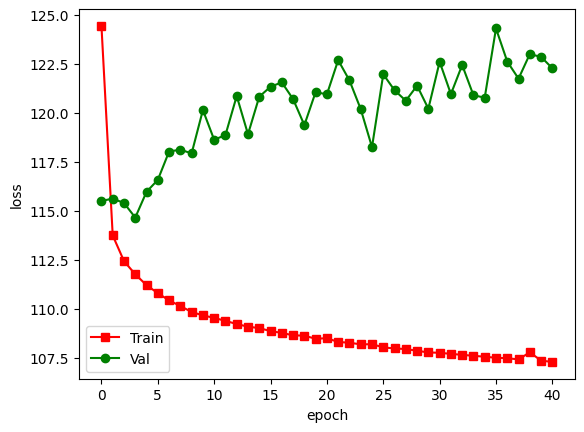

In [17]:
### 绘制loss曲线图

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(train_loss_list,'s-',color = 'r',label="Train")
plt.plot(val_loss_list,'o-',color = 'g',label="Val")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [6]:
### 加载模型 如果没有训练
model = torch.load("CNNLSTM_50.pth")

In [10]:
### 测试

# 设置测试集范围 [0, 1] 是0% 到 100%
test_range = [0, 1]

from PIL import Image
from tqdm import tqdm
import math

is_save_imgs = False   # 是否保存图片
data_num, height, width = label_array.shape
num_s = int(data_num*test_range[0])
num_e = int(data_num*test_range[1])
test_dataset = CustomDataset(data_array[num_s : num_e], label_array[num_s : num_e])
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
seq_test = len(test_loader)

if is_save_imgs:
    import os
    output_dir = 'output_images_test'
    os.makedirs(output_dir, exist_ok=True)

# test
model.eval()
test_loss = 0
rmse = 0
outList = np.zeros([seq_test+length, height, width])
criterion = torch.nn.MSELoss()
with torch.no_grad():
    for i, (batch_data, batch_labels) in enumerate(tqdm(test_loader)):
        batch_data = batch_data.to(device)
        batch_labels = batch_labels.to(device)
        out = model(batch_data)
        if i == 0:
            outList[i:i+10] = out[0].detach().squeeze().cpu().numpy()
        else:
            outList[i+10] = out[0][-1].detach().squeeze().cpu().numpy()
        loss = criterion(out, batch_labels)
        rmse += math.sqrt(loss.item())
        test_loss += loss.item()

        # 保存图片
        if is_save_imgs: save_img(batch_data, out, batch_labels=batch_labels, num=i, output_dir=output_dir)           
    
print(f'Test Loss:\nMSE: {test_loss/len(test_loader)}\nRMSE: {rmse/len(test_loader)}')

100%|██████████| 4990/4990 [04:09<00:00, 20.01it/s]

Test Loss:
MSE: 123.0371238662628
RMSE: 11.090368832393478


In [ ]:
### 保存测试数据到 .mat 文件中
import scipy
outList = outList.transpose(1,2,0)
scipy.io.savemat('outList.mat', {'ImgBuf3': outList})